# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [74]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [75]:
#preprocessing tools
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
#modelling
from xgboost import XGBClassifier
#evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._


In [76]:
print("Shape --> ", train.shape, "\n")
print("Data Types --> ", "\n", train.dtypes)
train.head(20)

Shape -->  (51916, 17) 

Data Types -->  
 Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0
5,1725221,LAKEVIEW REHABILITATION AND NURSING CENTER,LAKEVIEW REHABILITATION AND NURSING CENTER,2245580.0,Long Term Care,Risk 1 (High),735 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2016-02-22T00:00:00,Canvass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.932632,-87.647973,"{'longitude': '-87.64797278441709', 'latitude'...",0
6,1981372,GOLD COAST DOGS,GOLD COAST DOGS,32318.0,Restaurant,Risk 2 (Medium),225 S CANAL ST,CHICAGO,IL,60606.0,2017-01-12T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.878531,-87.639427,"{'longitude': '-87.63942745962717', 'latitude'...",0
7,1072403,HAPPY PIZZA,NaN,2241028.0,Restaurant,Risk 1 (High),8710 S HALSTED ST,CHICAGO,IL,60620.0,2013-05-07T00:00:00,License Re-Inspection,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.735505,-87.643749,"{'longitude': '-87.64374906595162', 'latitude'...",0
8,1464616,THE PUMPING CO INC,THE PUMPING CO,1544937.0,Restaurant,Risk 1 (High),6157 N BROADWAY,CHICAGO,IL,60660.0,2014-11-28T00:00:00,Canvass,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.993973,-87.660242,"{'longitude': '-87.66024237516903', 'latitude'...",1
9,583261,YUMMY YUMMY NOODLES,YUMMY YUMMY NOODLES,2098003.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,2011-06-01T00:00:00,License,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.855282,-87.631993,"{'longitude': '-87.63199264229414', 'latitude'...",1


There seem to be a number of useless or redundant features to strip.
To remove:
    * Inspection ID
    * DBA Name
    * AKA Name
    * License #
    * Address (redundant)
    * State (Only Illinois)
    * Lat + Log and Location (internally and externally redundant)
    
Which leaves us with:
    * Facility Type 
    * Risk --> Three types
    * City
    * Zip
    * Inspection Date --> Should be able to extract Delta
    * Inspection Type 
    * Violations --> Type and Number of Violations

In [77]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [78]:
# wrangling function to get our data ready for modelling

def wrangle(df):
    
    df = df.copy()
    
    # drop unwanted columns
    df = df.drop(['Inspection ID', 
                  'DBA Name', 
                  'AKA Name', 
                  'License #', 
                  'Address',
                  'State',
                  'Location', 
                  'Longitude', 
                  'Latitude'],
                   axis=1)
    
    # string reformation (ML style)
    cat_str = ['Risk', 
               'Facility Type',
               'City',
               'Inspection Type']
    for i in cat_str:
        df[i] = df[i].str.lower()
        
    # reformat risk   
    risk_dictionary = {'risk 1 (high)':1,
                       'risk 2 (medium)':2,
                       'risk 3 (low)':3}
    df['Risk'] = df['Risk'].replace(risk_dictionary)
        
    # taking care of null values --> Unknown = unkn
    df['Facility Type'] = df['Facility Type'].fillna('unkn')
    df['Risk'] = df['Risk'].fillna('unkn')
    df['City'] = df['City'].fillna('chicago')
    df['Zip'] = df['Zip'].fillna(0)
    df['Inspection Type'] = df['Inspection Type'].fillna('unkn')
    
    # convert to date time
    df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
    df['Inspection Date'] = pd.Timestamp.today() - df['Inspection Date']
    df['Inspection Delta'] = df['Inspection Date'].dt.days #time since last inspection in days
    df = df.drop(columns='Inspection Date')
    
    # number of violations
    df['v_count'] = df['Violations'].str.count('\|') + 1
    df['v_count'] = df['v_count'].fillna(0)
    
    # violation type
    df['v_type'] = df['Violations'].str.findall('^(\d+)\.\s') # pick out violation numbers
    df['v_type'] = df['v_type'].fillna('N') # None
    df['v_type'] = [','.join(map(str, violation)) for violation in df['v_type']] # Reformat arrays in single arr
    df = df.drop(columns='Violations')
    
    return df

In [79]:
# apply wrangle to train and test
df_train = wrangle(train)
df_test = wrangle(test)

In [89]:
df_train.head(10)

,Facility Type,Risk,City,Zip,Inspection Type,Fail,Inspection Delta,v_count,v_type
0,restaurant,1,chicago,60657.0,canvass,1,568,5.0,3
1,grocery store,3,chicago,60636.0,complaint re-inspection,0,2725,7.0,32
2,restaurant,1,chicago,60649.0,canvass re-inspection,0,1096,1.0,35
3,restaurant,2,chicago,60632.0,canvass,0,1072,2.0,38
4,school,1,chicago,60629.0,canvass,0,3008,3.0,34
5,long term care,1,chicago,60614.0,canvass,0,1139,7.0,31
6,restaurant,2,chicago,60606.0,canvass,0,814,3.0,30
7,restaurant,1,chicago,60620.0,license re-inspection,0,2160,1.0,38
8,restaurant,1,chicago,60660.0,canvass,1,1590,5.0,16
9,restaurant,1,chicago,60616.0,license,1,2866,5.0,18


In [81]:
df_train.isna().sum()

Facility Type       0
Risk                0
City                0
Zip                 0
Inspection Type     0
Fail                0
Inspection Delta    0
v_count             0
v_type              0
dtype: int64

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


In [84]:
ziel = df_train_trans['Fail']

# separating train goal
y_train = df_train_trans['Fail']
X_train = df_train_trans.drop(columns= "Fail")
# separating test goal
y_test = df_test_trans['Fail']
X_test = df_test_trans.drop(columns= "Fail")

In [94]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

# these scores are good but not extreme

[CV]  ................................................................
[CV] ....................... , score=0.9736231785649133, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ....................... , score=0.9722056516166863, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] ....................... , score=0.9741794405473283, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ....................... , score=0.9713874023725235, total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s


[CV] ....................... , score=0.9711776693068358, total=   2.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s finished


array([0.97362318, 0.97220565, 0.97417944, 0.9713874 , 0.97117767])

In [97]:
pipe.fit(X_train, y_train)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC:', roc_auc_score(y_train, y_pred_proba))

ROC AUC: 0.9673943412070212


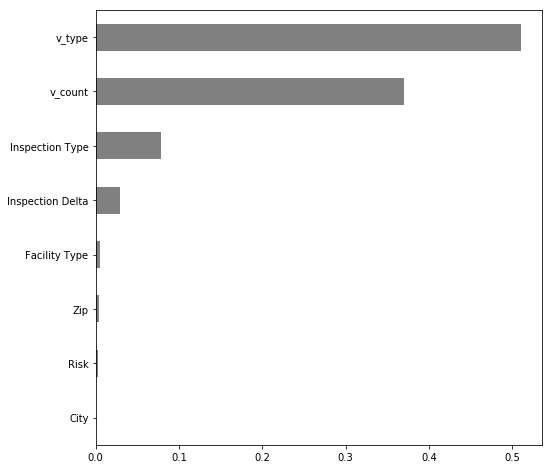

In [86]:
def show_feature_importances(
    pipe, X, y, estimator_name='randomforestclassifier', 
    n=20, figsize=(8, 8)):
    
    # pipe must not change dimensions of X dataframe
    pipe.fit(X, y)
    
    importances = pd.Series(
        pipe.named_steps[estimator_name].feature_importances_, 
        X.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')

    
show_feature_importances(pipe, X_train, y_train)

As suspected, the type of violation is the most important feature for predicting whether an establishment fails their inspection followed closely by the number of violations.

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

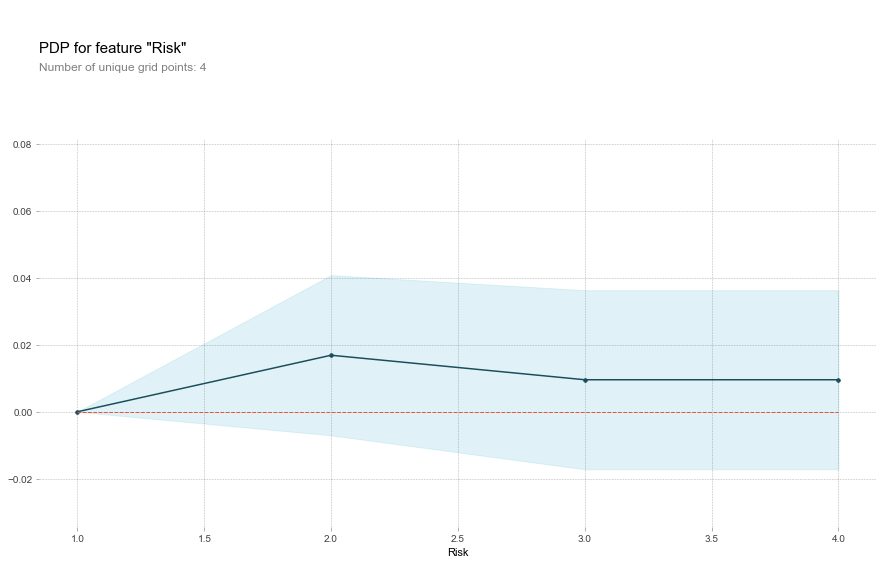

In [99]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Risk'

pdp_isolated = pdp_isolate(model=pipe, dataset=X_train, 
                           model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

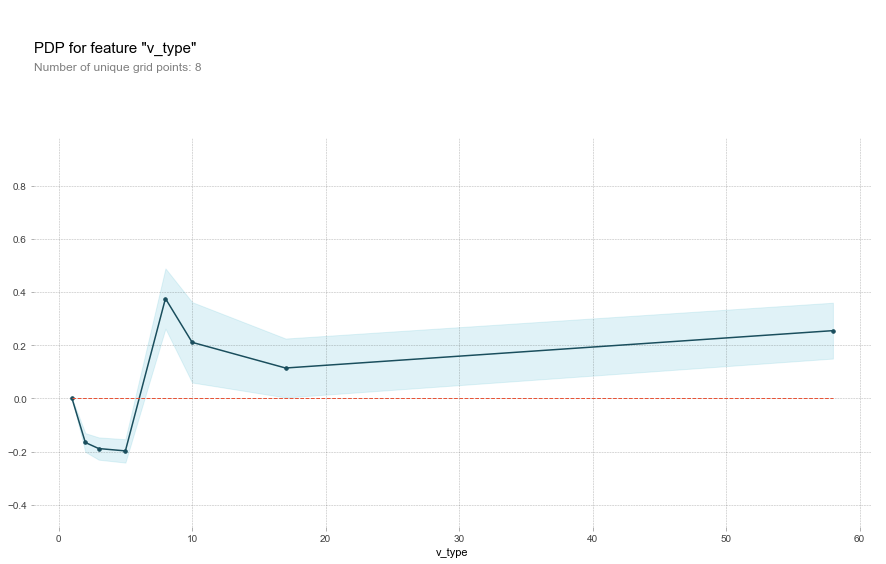

In [100]:
feature='v_type'

pdp_isolated = pdp_isolate(model=pipe, dataset=X_train, 
                           model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);